In [1]:
import wandb
wandb.login(key='f56388c51b488c425a228537fd2d35e5498a3a91')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/sathwikpentela/.netrc
wandb: Currently logged in as: da24m017 (da24m017-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, cell_type="LSTM"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        rnn_cls = {
            "RNN": nn.RNN,
            "GRU": nn.GRU,
            "LSTM": nn.LSTM
        }[cell_type]

        self.rnn = rnn_cls(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        self.cell_type = cell_type

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        outputs, hidden = self.rnn(embedded)  # outputs: all hidden states
        return hidden  # hidden: (num_layers, batch, hidden_size)


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, cell_type="LSTM"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        rnn_cls = {
            "RNN": nn.RNN,
            "GRU": nn.GRU,
            "LSTM": nn.LSTM
        }[cell_type]

        self.rnn = rnn_cls(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.cell_type = cell_type

    def forward(self, x, hidden):
        # x: [batch_size] -> unsqueezed to [batch_size, 1]
        x = x.unsqueeze(1)
        embedded = self.embedding(x)  # [batch_size, 1, embedding_dim]
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, vocab_size]
        return prediction, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)

        hidden = self.encoder(src)

        # handle LSTM's (hidden, cell) separately
        input = trg[:, 0]  # first input to decoder is <sos> token

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs


## 🧠 Question 1(a): Total Number of Computations

We analyze the total number of computations performed by the RNN-based seq2seq model, under the following assumptions:

---

### 🧩 Assumptions

Let:
- \( T \): Length of input/output sequences
- \( m \): Input embedding size
- \( k \): Hidden state size
- \( V \): Vocabulary size (same for both languages)
- Encoder and decoder have 1 layer each
- We use any RNN cell (Vanilla RNN / GRU / LSTM)
- Input and output sequence lengths are equal

---

### 🔹 Encoder RNN

Each time step performs the following:
- Multiply input \( x_t \in \mathbb{R}^m \) with weights \( W_{ih} \in \mathbb{R}^{k \times m} \):  
  → \( O(km) \)
- Multiply hidden state \( h_{t-1} \in \mathbb{R}^k \) with \( W_{hh} \in \mathbb{R}^{k \times k} \):  
  → \( O(k^2) \)

Ignoring biases and activation costs:
- **Per time step cost**: \( O(km + k^2) \)
- **Total for T steps**:  
  \[
  O(T(km + k^2))
  \]

---

### 🔸 Decoder RNN

The decoder runs for \( T \) steps as well:
- Same per-step cost as encoder
- **Total for T steps**:  
  \[
  O(T(km + k^2))
  \]

---

### 🟢 Output Projection Layer

Each decoder step outputs a probability over the vocabulary:
- Multiply \( h_t \in \mathbb{R}^k \) with \( W_o \in \mathbb{R}^{V \times k} \):  
  → \( O(Vk) \)

Total for \( T \) steps:  
\[
O(TVk)
\]

---

### ✅ Final Total Computation

\[
\text{Encoder: } O(T(km + k^2)) \\
\text{Decoder: } O(T(km + k^2)) \\
\text{Projection: } O(TVk)
\]

\[
\Rightarrow \boxed{O(T(2km + 2k^2 + Vk))}
\]

This is the total number of computations performed during a forward pass of the model.


## 🧠 Question 1(b): Total Number of Parameters

We now compute the total number of trainable parameters in the RNN-based seq2seq model, using the following assumptions:

---

### 🧩 Assumptions

Let:
- \( V \): Vocabulary size (same for source and target)
- \( m \): Input embedding size
- \( k \): Hidden state size
- Encoder and decoder have 1 layer each
- Same input/output vocabulary sizes
- Biases are included

---

### 🔷 Embedding Layers

- **Source embedding**: \( V \times m \)
- **Target embedding**: \( V \times m \)

\[
\Rightarrow \textbf{Total = } \boxed{2Vm}
\]

---

### 🔹 Encoder RNN Parameters

For a vanilla RNN cell:
- Input weights: \( W_{ih} \in \mathbb{R}^{k \times m} \Rightarrow km \)
- Recurrent weights: \( W_{hh} \in \mathbb{R}^{k \times k} \Rightarrow k^2 \)
- Bias: \( b \in \mathbb{R}^{k} \Rightarrow k \)

\[
\Rightarrow \textbf{Total = } \boxed{km + k^2 + k}
\]

(Note: GRU and LSTM have more parameters, but we're assuming a basic RNN cell for now.)

---

### 🔸 Decoder RNN Parameters

Same as encoder:

\[
\Rightarrow \textbf{Total = } \boxed{km + k^2 + k}
\]

---

### 🟢 Output Projection Layer

- Weights: \( W_o \in \mathbb{R}^{V \times k} \Rightarrow Vk \)
- Bias: \( b_o \in \mathbb{R}^{V} \Rightarrow V \)

\[
\Rightarrow \textbf{Total = } \boxed{Vk + V}
\]

---

### ✅ Final Parameter Count

\[
\text{Embeddings: } 2Vm \\
\text{Encoder RNN: } km + k^2 + k \\
\text{Decoder RNN: } km + k^2 + k \\
\text{Output Layer: } Vk + V
\]

\[
\Rightarrow \boxed{2Vm + 2km + 2k^2 + 2k + Vk + V}
\]

This is the total number of parameters in the network when using a 1-layer RNN encoder and decoder with matching vocabulary and hidden dimensions.


In [3]:
import pandas as pd
from pathlib import Path
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence

# File paths
BASE_PATH = Path("dakshina_dataset_v1.0/te/lexicons/")
TRAIN_FILE = BASE_PATH / "te.translit.sampled.train.tsv"
DEV_FILE = BASE_PATH / "te.translit.sampled.dev.tsv"
TEST_FILE = BASE_PATH / "te.translit.sampled.test.tsv"

# Load data
def load_data(file_path):
    data = pd.read_csv(file_path, sep="\t", header=None, names=["target", "input", "attestations"])
    data.dropna(subset=["input", "target"], inplace=True)
    data["input"] = data["input"].astype(str)
    data["target"] = data["target"].astype(str)
    return list(zip(data["input"], data["target"]))


train_pairs = load_data(TRAIN_FILE)
dev_pairs = load_data(DEV_FILE)
test_pairs = load_data(TEST_FILE)

print("Sample (roman -> native):", train_pairs[0])


Sample (roman -> native): ('amkita', 'అంకిత')


In [4]:
# Special tokens
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"

def build_vocab(pairs, is_input=True):
    counter = Counter()
    for src, tgt in pairs:
        text = src if is_input else tgt
        counter.update(list(text))
    chars = sorted(counter.keys())
    vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN] + chars
    char2idx = {char: idx for idx, char in enumerate(vocab)}
    idx2char = {idx: char for char, idx in char2idx.items()}
    return vocab, char2idx, idx2char

input_vocab, input2idx, idx2input = build_vocab(train_pairs, is_input=True)
target_vocab, target2idx, idx2target = build_vocab(train_pairs, is_input=False)

print(f"Input vocab size: {len(input_vocab)}")
print(f"Target vocab size: {len(target_vocab)}")


Input vocab size: 29
Target vocab size: 66


In [5]:
def encode_sequence(seq, char2idx, add_sos_eos=False):
    tokens = [char2idx[c] for c in seq]
    if add_sos_eos:
        return [char2idx[SOS_TOKEN]] + tokens + [char2idx[EOS_TOKEN]]
    else:
        return tokens

def tensorify(pairs, input2idx, target2idx):
    input_seqs = [torch.tensor(encode_sequence(src, input2idx), dtype=torch.long) for src, _ in pairs]
    target_seqs = [torch.tensor(encode_sequence(tgt, target2idx, add_sos_eos=True), dtype=torch.long) for _, tgt in pairs]
    return input_seqs, target_seqs

train_input, train_target = tensorify(train_pairs, input2idx, target2idx)
dev_input, dev_target = tensorify(dev_pairs, input2idx, target2idx)
test_input, test_target = tensorify(test_pairs, input2idx, target2idx)


In [6]:
from torch.utils.data import Dataset, DataLoader

class Seq2SeqDataset(Dataset):
    def __init__(self, input_seqs, target_seqs):
        self.input_seqs = input_seqs
        self.target_seqs = target_seqs

    def __len__(self):
        return len(self.input_seqs)

    def __getitem__(self, idx):
        return self.input_seqs[idx], self.target_seqs[idx]

# Collate function to pad a batch
def collate_fn(batch):
    input_batch, target_batch = zip(*batch)
    input_batch = pad_sequence(input_batch, batch_first=True, padding_value=input2idx[PAD_TOKEN])
    target_batch = pad_sequence(target_batch, batch_first=True, padding_value=target2idx[PAD_TOKEN])
    return input_batch, target_batch

# Create datasets
train_dataset = Seq2SeqDataset(train_input, train_target)
dev_dataset = Seq2SeqDataset(dev_input, dev_target)
test_dataset = Seq2SeqDataset(test_input, test_target)

# Create data loaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Peek at one batch
for x_batch, y_batch in train_loader:
    print("Input batch shape:", x_batch.shape)
    print("Target batch shape:", y_batch.shape)
    break


Input batch shape: torch.Size([64, 17])
Target batch shape: torch.Size([64, 14])


In [7]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.2, cell_type="LSTM"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[cell_type]

        self.rnn = rnn_cls(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )

        self.cell_type = cell_type

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, hidden = self.rnn(embedded)
        return hidden


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.2, cell_type="LSTM"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[cell_type]

        self.rnn = rnn_cls(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )

        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.cell_type = cell_type

    def forward(self, x, hidden):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)

        hidden = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs


In [8]:
import wandb
import torch.nn.functional as F

def compute_accuracy(preds, targets, pad_idx):
    preds = preds.argmax(dim=-1)
    mask = targets != pad_idx
    correct = (preds == targets) & mask
    return correct.sum().item() / mask.sum().item()


def train_one_epoch(model, dataloader, optimizer, criterion, device, pad_idx, teacher_forcing_ratio):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        output = model(src, tgt, teacher_forcing_ratio)

        output = output[:, 1:].reshape(-1, output.size(-1))
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        acc = compute_accuracy(output, tgt, pad_idx)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

    return total_loss / len(dataloader), total_acc / len(dataloader)


def evaluate(model, dataloader, criterion, device, pad_idx):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0)

            output = output[:, 1:].reshape(-1, output.size(-1))
            tgt = tgt[:, 1:].reshape(-1)

            loss = criterion(output, tgt)
            acc = compute_accuracy(output, tgt, pad_idx)

            total_loss += loss.item()
            total_acc += acc

    return total_loss / len(dataloader), total_acc / len(dataloader)


In [9]:
def run_training(config=None):
    with wandb.init(config=config):
        config = wandb.config

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        encoder = Encoder(
            vocab_size=len(input_vocab),
            embedding_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            num_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )

        decoder = Decoder(
            vocab_size=len(target_vocab),
            embedding_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            num_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )

        model = Seq2Seq(encoder, decoder, device).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.CrossEntropyLoss(ignore_index=target2idx[PAD_TOKEN])

        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, target2idx[PAD_TOKEN], config.teacher_forcing)
            val_loss, val_acc = evaluate(model, dev_loader, criterion, device, target2idx[PAD_TOKEN])

            # Log to wandb
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc
            })

            # Print to notebook
            print(f"[Epoch {epoch + 1:02}] "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        torch.save(model.state_dict(), "best_model.pth")


In [10]:
def run_training(config=None):
    with wandb.init(config=config):
        config = wandb.config

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        encoder = Encoder(
            vocab_size=len(input_vocab),
            embedding_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            num_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )

        decoder = Decoder(
            vocab_size=len(target_vocab),
            embedding_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            num_layers=config.num_layers,
            dropout=config.dropout,
            cell_type=config.cell_type
        )

        model = Seq2Seq(encoder, decoder, device).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.CrossEntropyLoss(ignore_index=target2idx[PAD_TOKEN])

        best_val_acc = 0.0

        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(
                model, train_loader, optimizer, criterion,
                device, target2idx[PAD_TOKEN], config.teacher_forcing
            )

            val_loss, val_acc = evaluate(
                model, dev_loader, criterion,
                device, target2idx[PAD_TOKEN]
            )

            is_best = val_acc > best_val_acc
            if is_best:
                best_val_acc = val_acc
                torch.save(model.state_dict(), "best_model.pth")

            # Log to WandB
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc
            })

            # Print to notebook
            print(f"[Epoch {epoch + 1:02}] "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} "
                  f"{'(Saved)' if is_best else ''}")


In [14]:
# wandb.init(project="DA6401_Assignment_3", name="baseline-run_1")

# config = {
#     "embedding_dim": 64,
#     "hidden_dim": 128,
#     "enc_layers": 1,
#     "dec_layers": 1,
#     "dropout": 0.3,
#     "cell_type": "GRU",
#     "lr": 0.001,
#     "epochs": 20,
#     "teacher_forcing": 0.5,
# }
#run_training(config)


In [15]:
sweep_config = {
    "method": "bayes",  # could also be "grid" or "bayes"
    "metric": {
        "name": "val_acc",
        "goal": "maximize"
    },
    "parameters": {
        "embedding_dim": {"values": [32, 64, 128, 256]},
        "hidden_dim": {"values": [32, 64, 128, 256]},
        "num_layers": {"values": [1, 2, 3]},
        "dropout": {"values": [0.0, 0.2, 0.4, 0.5]},
        "cell_type": {"values": ["RNN", "GRU", "LSTM"]},
        "lr": {"values": [0.001, 0.0005, 0.0001]},
        "teacher_forcing": {"values": [0.5, 0.7]},
        "epochs": {"value": 15}
    }
}


In [16]:
# sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_3")
# wandb.agent(sweep_id, function=run_training, count=25)  # You can increase count


In [17]:
best_config = {
    "embedding_dim": 64,
    "hidden_dim": 256,
    "num_layers": 3,
    "dropout": 0.5,
    "cell_type": "LSTM",
    "lr": 0.001,
    "teacher_forcing": 0.5,
    "epochs": 15
}


In [18]:
# import wandb

# wandb.init(project="DA6401_Assignment_3", name="best_config_rerun")
# run_training(best_config)


In [19]:
# # Use the same best_config used during training
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# encoder = Encoder(
#     vocab_size=len(input_vocab),
#     embedding_dim=best_config["embedding_dim"],
#     hidden_dim=best_config["hidden_dim"],
#     num_layers=best_config["num_layers"],
#     dropout=best_config["dropout"],
#     cell_type=best_config["cell_type"]
# )

# decoder = Decoder(
#     vocab_size=len(target_vocab),
#     embedding_dim=best_config["embedding_dim"],
#     hidden_dim=best_config["hidden_dim"],
#     num_layers=best_config["num_layers"],
#     dropout=best_config["dropout"],
#     cell_type=best_config["cell_type"]
# )

# model = Seq2Seq(encoder, decoder, device).to(device)
# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()


In [20]:
# sample_input = pad_sequence(test_input[:1], batch_first=True, padding_value=input2idx[PAD_TOKEN]).to(device)
# sample_target = pad_sequence(test_target[:1], batch_first=True, padding_value=target2idx[PAD_TOKEN]).to(device)

# with torch.no_grad():
#     output = model(sample_input, sample_target, teacher_forcing_ratio=0.0)
#     print("Output shape:", output.shape)


In [11]:
def tensorify(pairs, input2idx, target2idx, add_sos_eos=True):
    input_seqs = [torch.tensor(encode_sequence(src, input2idx), dtype=torch.long) for src, _ in pairs]
    target_seqs = [torch.tensor(encode_sequence(tgt, target2idx, add_sos_eos=add_sos_eos), dtype=torch.long) for _, tgt in pairs]
    return input_seqs, target_seqs
test_input, test_target = tensorify(test_pairs, input2idx, target2idx, add_sos_eos=True)  # ✅


In [12]:
def evaluate_exact_match(model, dataloader, device, idx2target, pad_idx):
    model.eval()
    total, correct = 0, 0
    predictions = []

    ignore = {pad_idx, target2idx[SOS_TOKEN], target2idx[EOS_TOKEN]}

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0.0)
            preds = output.argmax(dim=-1)

            for i in range(src.size(0)):
                tgt_str = "".join([idx2target[idx.item()] for idx in tgt[i] if idx.item() not in ignore])
                pred_str = "".join([idx2target[idx.item()] for idx in preds[i] if idx.item() not in ignore])
                predictions.append((tgt_str, pred_str))
                if pred_str == tgt_str:
                    correct += 1
                total += 1

    accuracy = correct / total
    return accuracy, predictions


In [23]:
# test_acc, test_preds = evaluate_exact_match(model, test_loader, device, idx2target, target2idx[PAD_TOKEN])
# print(f"\n✅ Exact Match Accuracy on Test Set: {test_acc * 100:.2f}%")

In [24]:
# import pandas as pd
# from pathlib import Path

# # Get Roman inputs again
# roman_inputs = [x[0] for x in test_pairs]

# # Sanity check: match input length
# assert len(roman_inputs) == len(test_preds)

# # Create DataFrame
# df_preds = pd.DataFrame({
#     "Input (Roman)": roman_inputs,
#     "Ground Truth (Telugu)": [gt for gt, _ in test_preds],
#     "Prediction (Telugu)": [pred for _, pred in test_preds],
#     "Match": [gt == pred for gt, pred in test_preds]
# })

# # Save to predictions_vanilla folder
# Path("predictions_vanilla").mkdir(exist_ok=True)
# df_preds.to_csv("predictions_vanilla/test_predictions_old.csv", index=False)

# # Preview top rows
# df_preds.head()


In [25]:
# from IPython.display import display, HTML

# # Sample 8 examples (some matches, some mismatches)
# sampled_df = df_preds.sample(n=8, random_state=42)

# # Add green check / red cross to Match column
# def match_icon(match):
#     return "✅" if match else "❌"

# sampled_df["Correct"] = sampled_df["Match"].apply(match_icon)
# sampled_df = sampled_df.drop(columns=["Match"])

# # Style and display as HTML table
# display(HTML(sampled_df.to_html(index=False)))


In [13]:
class AttentionEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, cell_type="LSTM"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[cell_type]
        self.rnn = rnn_cls(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=dropout
        )
        self.cell_type = cell_type

    def forward(self, src):
        embedded = self.embedding(src)  # [batch, src_len, emb_dim]
        outputs, hidden = self.rnn(embedded)  # outputs: [batch, src_len, hidden_dim]
        return outputs, hidden


In [14]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(encoder_hidden_dim + decoder_hidden_dim, decoder_hidden_dim)
        self.v = nn.Linear(decoder_hidden_dim, 1, bias=False)  # 🔄 Replaces raw vector

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch, dec_hidden_dim]
        # encoder_outputs: [batch, src_len, enc_hidden_dim]

        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch, src_len, dec_hidden_dim]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch, src_len, dec_hidden_dim]

        # 🔁 v is now a linear layer
        attention = self.v(energy).squeeze(2)  # [batch, src_len]

        return F.softmax(attention, dim=1)  # [batch, src_len]


In [15]:
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, enc_hidden_dim, dec_hidden_dim, dropout, cell_type="LSTM"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(enc_hidden_dim, dec_hidden_dim)
        self.rnn_input_dim = embedding_dim + enc_hidden_dim

        rnn_cls = {"RNN": nn.RNN, "GRU": nn.GRU, "LSTM": nn.LSTM}[cell_type]
        self.rnn = rnn_cls(
            input_size=self.rnn_input_dim,
            hidden_size=dec_hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.cell_type = cell_type

    def forward(self, input_token, hidden, encoder_outputs):
        # input_token: [batch]
        # hidden: [1, batch, dec_hidden_dim] or (h, c)
        # encoder_outputs: [batch, src_len, enc_hidden_dim]

        input_token = input_token.unsqueeze(1)  # [batch, 1]
        embedded = self.dropout(self.embedding(input_token))  # [batch, 1, emb_dim]

        if self.cell_type == "LSTM":
            decoder_hidden = hidden[0][-1]  # last layer's hidden state
        else:
            decoder_hidden = hidden[-1]  # [batch, dec_hidden_dim]

        attn_weights = self.attention(decoder_hidden, encoder_outputs)  # [batch, src_len]
        attn_weights = attn_weights.unsqueeze(1)  # [batch, 1, src_len]
        context = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, enc_hidden_dim]

        rnn_input = torch.cat((embedded, context), dim=2)  # [batch, 1, emb+context]
        output, hidden = self.rnn(rnn_input, hidden)

        output = output.squeeze(1)      # [batch, dec_hidden_dim]
        context = context.squeeze(1)    # [batch, enc_hidden_dim]
        embedded = embedded.squeeze(1)  # [batch, emb_dim]

        output = self.fc_out(torch.cat((output, context, embedded), dim=1))  # [batch, vocab_size]
        return output, hidden, attn_weights.squeeze(1)  # return attention weights for visualization


In [16]:
class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src.size(1)).to(self.device)

        # Encoder forward
        encoder_outputs, hidden = self.encoder(src)

        # Initialize first input to decoder
        input_token = trg[:, 0]  # <sos>

        for t in range(1, trg_len):
            output, hidden, attn_weights = self.decoder(input_token, hidden, encoder_outputs)
            outputs[:, t] = output
            attentions[:, t] = attn_weights

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1

        return outputs, attentions  # [batch, trg_len, vocab_size], [batch, trg_len, src_len]


In [17]:
def run_attention_training():
    with wandb.init() as run:
        config = run.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Encoder and Decoder setup
        encoder = AttentionEncoder(
            vocab_size=len(input_vocab),
            embedding_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            dropout=config.dropout,
            cell_type=config.cell_type
        )

        decoder = AttentionDecoder(
            vocab_size=len(target_vocab),
            embedding_dim=config.embedding_dim,
            enc_hidden_dim=config.hidden_dim,
            dec_hidden_dim=config.hidden_dim,
            dropout=config.dropout,
            cell_type=config.cell_type
        )

        model = AttentionSeq2Seq(encoder, decoder, device).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.CrossEntropyLoss(ignore_index=target2idx[PAD_TOKEN])

        best_val_acc = 0.0

        for epoch in range(config.epochs):
            model.train()
            total_loss, total_acc = 0.0, 0.0

            for src, tgt in train_loader:
                src, tgt = src.to(device), tgt.to(device)
                optimizer.zero_grad()
                output, _ = model(src, tgt, teacher_forcing_ratio=config.teacher_forcing)

                output = output[:, 1:].reshape(-1, output.size(-1))
                tgt_gold = tgt[:, 1:].reshape(-1)

                loss = criterion(output, tgt_gold)
                acc = compute_accuracy(output, tgt_gold, target2idx[PAD_TOKEN])

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_acc += acc

            train_loss = total_loss / len(train_loader)
            train_acc = total_acc / len(train_loader)

            # Validation
            val_loss, val_acc = evaluate_attention_model(model, dev_loader, criterion, device, target2idx[PAD_TOKEN])

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), "best_model_attn.pth")

            # Logging
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc
            })

            print(f"[Epoch {epoch + 1:02}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
                  f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} "
                  f"{'(Saved)' if val_acc == best_val_acc else ''}")


In [18]:
def evaluate_attention_model(model, dataloader, criterion, device, pad_idx):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    attn_sum = 0.0
    attn_count = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output, attentions = model(src, tgt, teacher_forcing_ratio=0.0)

            output = output[:, 1:].reshape(-1, output.size(-1))
            tgt_gold = tgt[:, 1:].reshape(-1)

            loss = criterion(output, tgt_gold)
            acc = compute_accuracy(output, tgt_gold, pad_idx)

            total_loss += loss.item()
            total_acc += acc

            # 🔍 Track mean attention value
            attn_sum += attentions.sum().item()
            attn_count += attentions.numel()

    mean_attn = attn_sum / attn_count if attn_count > 0 else 0.0
    print(f"🔍 Mean Attention Weight: {mean_attn:.4f}")

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [ ]:
best_attn_config = {
    "embedding_dim": 128,
    "hidden_dim": 256,
    "dropout": 0.5,
    "cell_type": "LSTM",
    "lr": 0.001,
    "teacher_forcing": 0.5,
    "epochs": 10
}

import wandb

# Run manually without sweep
wandb.init(project="DA6401_Assignment_3", name="attention_single_run", config=best_attn_config)
run_attention_training()


In [ ]:
import wandb

sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "val_acc",
        "goal": "maximize"
    },
    "parameters": {
        "embedding_dim": {"values": [32, 64, 128, 256]},
        "hidden_dim": {"values": [32, 64, 128, 256]},
        "dropout": {"values": [0.0, 0.2, 0.4, 0.5]},
        "cell_type": {"values": ["RNN", "GRU", "LSTM"]},
        "lr": {"values": [0.001, 0.0005, 0.0001]},
        "teacher_forcing": {"values": [0.5, 0.7]},
        "epochs": {"value": 10}
    }
}

# 1. Create the sweep
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_3")

# 2. Run the sweep with 25 trials (you can increase if needed)
wandb.agent(sweep_id, function=run_attention_training, count=20)


In [ ]:
# sweep_config = {
#     "method": "bayes",  # could also be "grid" or "bayes"
#     "metric": {
#         "name": "val_acc",
#         "goal": "maximize"
#     },
#     "parameters": {
#         "embedding_dim": {"values": [32, 64, 128, 256]},
#         "hidden_dim": {"values": [32, 64, 128, 256]},
#         "dropout": {"values": [0.0, 0.2, 0.4, 0.5]},
#         "cell_type": {"values": ["RNN", "GRU", "LSTM"]},
#         "lr": {"values": [0.001, 0.0005, 0.0001]},
#         "teacher_forcing": {"values": [0.5, 0.7]},
#         "epochs": {"value": 10}
#     }
# }


In [ ]:
# import wandb

# # Create sweep
# sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_3")

# # Run the sweep with N trials
# wandb.agent(sweep_id, function=run_attention_training, count=25)  # Increase count if needed


In [19]:
def run_attention_training():
    best_attn_config = {
        "embedding_dim": 256,
        "hidden_dim": 256,
        "dropout": 0.2,
        "cell_type": "LSTM",
        "lr": 0.001,
        "teacher_forcing": 0.7,
        "epochs": 10
    }

    with wandb.init(project="DA6401_Assignment_3", name="best_attention_final", config=best_attn_config):
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        encoder = AttentionEncoder(
            vocab_size=len(input_vocab),
            embedding_dim=config.embedding_dim,
            hidden_dim=config.hidden_dim,
            dropout=config.dropout,
            cell_type=config.cell_type
        )

        decoder = AttentionDecoder(
            vocab_size=len(target_vocab),
            embedding_dim=config.embedding_dim,
            enc_hidden_dim=config.hidden_dim,
            dec_hidden_dim=config.hidden_dim,
            dropout=config.dropout,
            cell_type=config.cell_type
        )

        model = AttentionSeq2Seq(encoder, decoder, device).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.CrossEntropyLoss(ignore_index=target2idx[PAD_TOKEN])

        best_val_acc = 0.0

        for epoch in range(config.epochs):
            model.train()
            total_loss, total_acc = 0.0, 0.0

            for src, tgt in train_loader:
                src, tgt = src.to(device), tgt.to(device)
                optimizer.zero_grad()
                output, _ = model(src, tgt, teacher_forcing_ratio=config.teacher_forcing)

                output = output[:, 1:].reshape(-1, output.size(-1))
                tgt_gold = tgt[:, 1:].reshape(-1)

                loss = criterion(output, tgt_gold)
                acc = compute_accuracy(output, tgt_gold, target2idx[PAD_TOKEN])

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_acc += acc

            train_loss = total_loss / len(train_loader)
            train_acc = total_acc / len(train_loader)

            # Validation
            val_loss, val_acc = evaluate_attention_model(model, dev_loader, criterion, device, target2idx[PAD_TOKEN])

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), "best_model_attn.pth")

            # Logging
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc
            })

            print(f"[Epoch {epoch + 1:02}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
                  f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} "
                  f"{'(Saved)' if val_acc == best_val_acc else ''}")


In [ ]:
# run_attention_training()

In [20]:
import torch

# === Configuration used during training ===
best_attn_config = {
    "embedding_dim": 256,
    "hidden_dim": 256,
    "dropout": 0.2,
    "cell_type": "LSTM"
}

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Rebuild the model architecture ===
encoder = AttentionEncoder(
    vocab_size=len(input_vocab),
    embedding_dim=best_attn_config["embedding_dim"],
    hidden_dim=best_attn_config["hidden_dim"],
    dropout=best_attn_config["dropout"],
    cell_type=best_attn_config["cell_type"]
)

decoder = AttentionDecoder(
    vocab_size=len(target_vocab),
    embedding_dim=best_attn_config["embedding_dim"],
    enc_hidden_dim=best_attn_config["hidden_dim"],
    dec_hidden_dim=best_attn_config["hidden_dim"],
    dropout=best_attn_config["dropout"],
    cell_type=best_attn_config["cell_type"]
)

model_attn = AttentionSeq2Seq(encoder, decoder, device).to(device)

# === Load weights from saved .pth file ===
checkpoint_path = "best_model_attn (2).pth"
model_attn.load_state_dict(torch.load(checkpoint_path, map_location=device))
model_attn.eval()

print("✅ Loaded best attention model successfully!")


✅ Loaded best attention model successfully!


/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [21]:
def detokenize(token_ids, idx2char):
    """Converts list of token ids to string (removes special tokens like PAD/SOS/EOS)."""
    return ''.join([idx2char[idx] for idx in token_ids if idx2char[idx] not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]])

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
def tokenize(text, vocab, add_sos_eos=False):
    tokens = [vocab[char] for char in text if char in vocab]
    if add_sos_eos:
        tokens = [vocab[SOS_TOKEN]] + tokens + [vocab[EOS_TOKEN]]
    return tokens

def detokenize(token_ids, idx2char):
    return ''.join([idx2char[idx] for idx in token_ids if idx in idx2char and idx2char[idx] not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]])


In [25]:
from matplotlib.font_manager import FontProperties

# Load the Telugu-compatible font
telugu_font = FontProperties(fname="Noto_Sans_Telugu/static/NotoSansTelugu-Black.ttf")

def visualize_attention(model, input_text, input2idx, idx2target, target2idx, device, max_len=30):
    model.eval()
    src_tensor = torch.tensor([tokenize(input_text, input2idx, add_sos_eos=True)], device=device)
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    input_chars = [SOS_TOKEN] + list(input_text) + [EOS_TOKEN]
    pred_chars = []
    attentions = []

    input_token = torch.tensor([target2idx[SOS_TOKEN]], device=device)

    for _ in range(max_len):
        with torch.no_grad():
            output, hidden, attn_weights = model.decoder(input_token, hidden, encoder_outputs)
            top1 = output.argmax(1).item()
            pred_chars.append(idx2target[top1])
            attentions.append(attn_weights.squeeze(0).cpu().numpy())
        if idx2target[top1] == EOS_TOKEN:
            break
        input_token = torch.tensor([top1], device=device)

    attn_matrix = np.stack(attentions)

    plt.figure(figsize=(12, 6))
    sns.heatmap(attn_matrix, xticklabels=input_chars, yticklabels=pred_chars, cmap="viridis")

    plt.xticks(fontproperties=telugu_font, rotation=0, fontsize=12)
    plt.yticks(fontproperties=telugu_font, rotation=0, fontsize=12)
    plt.xlabel("Input Characters", fontproperties=telugu_font)
    plt.ylabel("Predicted Characters", fontproperties=telugu_font)
    plt.title(f"Attention Heatmap for: {input_text}", fontproperties=telugu_font, fontsize=14)
    plt.show()


/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3112 (\N{TELUGU LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.draw()
/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3143 (\N{TELUGU VOWEL SIGN EE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3107 (\N{TELUGU LETTER NNA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 3137 (\N{TELUGU VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/sathwikpentela/miniforge3/en

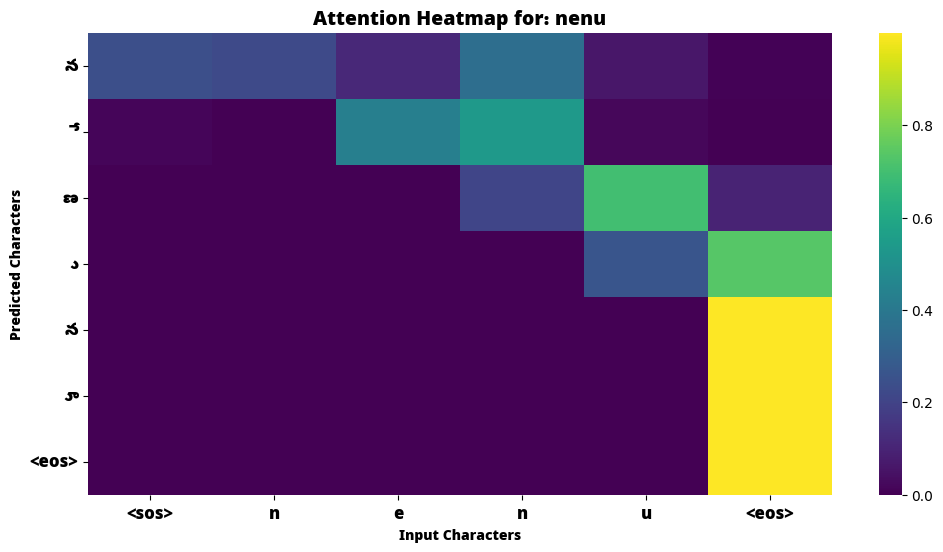

In [26]:
visualize_attention(model_attn, "nenu", input2idx, idx2target, target2idx, device)

In [27]:
# Recreate the model with best config
encoder = AttentionEncoder(
    vocab_size=len(input_vocab),
    embedding_dim=256,
    hidden_dim=256,
    dropout=0.2,
    cell_type="LSTM"
)

decoder = AttentionDecoder(
    vocab_size=len(target_vocab),
    embedding_dim=256,
    enc_hidden_dim=256,
    dec_hidden_dim=256,
    dropout=0.2,
    cell_type="LSTM"
)

model_attn = AttentionSeq2Seq(encoder, decoder, device).to(device)
model_attn.load_state_dict(torch.load("best_model_attn (2).pth", map_location=torch.device('cpu')))
model_attn.eval()


/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


AttentionSeq2Seq(
  (encoder): AttentionEncoder(
    (embedding): Embedding(29, 256)
    (rnn): LSTM(256, 256, batch_first=True, dropout=0.2)
  )
  (decoder): AttentionDecoder(
    (embedding): Embedding(66, 256)
    (attention): BahdanauAttention(
      (attn): Linear(in_features=512, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): LSTM(512, 256, batch_first=True)
    (fc_out): Linear(in_features=768, out_features=66, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [28]:
def evaluate_exact_match(model, dataloader, device, idx2target, pad_idx):
    model.eval()
    correct, total = 0, 0
    predictions = []
    eos_idx = target2idx[EOS_TOKEN]

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output, _ = model(src, tgt, teacher_forcing_ratio=0.0)

            preds = output.argmax(dim=-1)

            for i in range(src.size(0)):
                pred_tokens = preds[i].tolist()
                tgt_tokens = tgt[i].tolist()

                if eos_idx in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(eos_idx)]
                if eos_idx in tgt_tokens:
                    tgt_tokens = tgt_tokens[:tgt_tokens.index(eos_idx)]

                pred_str = detokenize(pred_tokens, idx2target)
                tgt_str = detokenize(tgt_tokens, idx2target)

                predictions.append((tgt_str, pred_str))
                if pred_str == tgt_str:
                    correct += 1
                total += 1

    return correct / total, predictions


In [29]:
attn_test_acc, attn_preds = evaluate_exact_match(
    model_attn, test_loader, device, idx2target, target2idx[PAD_TOKEN])

print(f"✅ Attention Model Exact Match Accuracy on Test Set: {attn_test_acc * 100:.2f}%")

✅ Attention Model Exact Match Accuracy on Test Set: 55.59%


In [47]:
# from pathlib import Path
# import pandas as pd

# Path("predictions_attention").mkdir(exist_ok=True)

# pd.DataFrame({
#     "Input (Roman)": [x[0] for x in test_pairs],
#     "Ground Truth (Telugu)": [g for g, _ in attn_preds],
#     "Prediction (Telugu)": [p for _, p in attn_preds],
#     "Match": [g == p for g, p in attn_preds]
# }).to_csv("predictions_attention/test_predictions.csv", index=False)

In [30]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=input2idx[PAD_TOKEN])
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=target2idx[PAD_TOKEN])
    return src_batch, tgt_batch


In [31]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import pandas as pd

# ========= 1. Rebuild Vanilla Model =========
best_config = {
    "embedding_dim": 64,
    "hidden_dim": 256,
    "num_layers": 3,
    "dropout": 0.5,
    "cell_type": "LSTM"
}

vanilla_encoder = Encoder(
    vocab_size=len(input_vocab),
    embedding_dim=best_config["embedding_dim"],
    hidden_dim=best_config["hidden_dim"],
    num_layers=best_config["num_layers"],
    dropout=best_config["dropout"],
    cell_type=best_config["cell_type"]
)

vanilla_decoder = Decoder(
    vocab_size=len(target_vocab),
    embedding_dim=best_config["embedding_dim"],
    hidden_dim=best_config["hidden_dim"],
    num_layers=best_config["num_layers"],
    dropout=best_config["dropout"],
    cell_type=best_config["cell_type"]
)

model_vanilla = Seq2Seq(vanilla_encoder, vanilla_decoder, device).to(device)
model_vanilla.load_state_dict(torch.load("best_model (1).pth", map_location=torch.device('cpu')))
model_vanilla.eval()

# ========= 2. Rebuild Attention Model =========
best_attn_config = {
    "embedding_dim": 256,
    "hidden_dim": 256,
    "dropout": 0.2,
    "cell_type": "LSTM"
}

attn_encoder = AttentionEncoder(
    vocab_size=len(input_vocab),
    embedding_dim=best_attn_config["embedding_dim"],
    hidden_dim=best_attn_config["hidden_dim"],
    dropout=best_attn_config["dropout"],
    cell_type=best_attn_config["cell_type"]
)

attn_decoder = AttentionDecoder(
    vocab_size=len(target_vocab),
    embedding_dim=best_attn_config["embedding_dim"],
    enc_hidden_dim=best_attn_config["hidden_dim"],
    dec_hidden_dim=best_attn_config["hidden_dim"],
    dropout=best_attn_config["dropout"],
    cell_type=best_attn_config["cell_type"]
)

model_attn = AttentionSeq2Seq(attn_encoder, attn_decoder, device).to(device)
model_attn.load_state_dict(torch.load("best_model_attn (2).pth", map_location=torch.device('cpu')))
model_attn.eval()

# ========= 3. Prepare Test Set =========
test_input, test_target = tensorify(test_pairs, input2idx, target2idx, add_sos_eos=True)
test_dataset = Seq2SeqDataset(test_input, test_target)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=pad_collate)

# ========= 4. Detokenize Helper =========
def detokenize(token_ids, idx2char):
    return ''.join([idx2char[idx] for idx in token_ids if idx2char[idx] not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]])

# ========= 5. Exact Match Evaluator =========
def evaluate_exact_match(model, dataloader, device, idx2target, pad_idx):
    model.eval()
    correct, total = 0, 0
    predictions = []
    eos_idx = target2idx[EOS_TOKEN]

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0.0)
            if isinstance(output, tuple):  # handle (output, attn)
                output = output[0]

            preds = output.argmax(dim=-1)

            for i in range(src.size(0)):
                pred_tokens = preds[i].tolist()
                tgt_tokens = tgt[i].tolist()

                if eos_idx in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(eos_idx)]
                if eos_idx in tgt_tokens:
                    tgt_tokens = tgt_tokens[:tgt_tokens.index(eos_idx)]

                pred_str = detokenize(pred_tokens, idx2target)
                tgt_str = detokenize(tgt_tokens, idx2target)

                predictions.append((tgt_str, pred_str))
                if pred_str == tgt_str:
                    correct += 1
                total += 1

    return correct / total, predictions

# ========= 6. Evaluate Both Models =========
vanilla_acc, vanilla_preds = evaluate_exact_match(
    model_vanilla, test_loader, device, idx2target, target2idx[PAD_TOKEN])

attn_acc, attn_preds = evaluate_exact_match(
    model_attn, test_loader, device, idx2target, target2idx[PAD_TOKEN])

print(f"✅ Vanilla Seq2Seq Accuracy: {vanilla_acc * 100:.2f}%")
print(f"✅ Attention Seq2Seq Accuracy: {attn_acc * 100:.2f}%")


✅ Vanilla Seq2Seq Accuracy: 54.24%
✅ Attention Seq2Seq Accuracy: 55.59%


In [32]:
# ========= 3. Prepare Test Set =========
test_input, test_target = tensorify(test_pairs, input2idx, target2idx, add_sos_eos=True)
test_dataset = Seq2SeqDataset(test_input, test_target)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=pad_collate)

# ========= 4. Detokenize Helper =========
def detokenize(token_ids, idx2char):
    return ''.join([idx2char[idx] for idx in token_ids if idx2char[idx] not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]])

# ========= 5. Exact Match Evaluator =========
def evaluate_exact_match(model, dataloader, device, idx2target, pad_idx):
    model.eval()
    correct, total = 0, 0
    predictions = []
    eos_idx = target2idx[EOS_TOKEN]

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, teacher_forcing_ratio=0.0)
            if isinstance(output, tuple):  # handle (output, attn)
                output = output[0]

            preds = output.argmax(dim=-1)

            for i in range(src.size(0)):
                pred_tokens = preds[i].tolist()
                tgt_tokens = tgt[i].tolist()

                if eos_idx in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(eos_idx)]
                if eos_idx in tgt_tokens:
                    tgt_tokens = tgt_tokens[:tgt_tokens.index(eos_idx)]

                pred_str = detokenize(pred_tokens, idx2target)
                tgt_str = detokenize(tgt_tokens, idx2target)

                predictions.append((tgt_str, pred_str))
                if pred_str == tgt_str:
                    correct += 1
                total += 1

    return correct / total, predictions

# ========= 6. Evaluate Both Models =========
vanilla_acc, vanilla_preds = evaluate_exact_match(
    model_vanilla, test_loader, device, idx2target, target2idx[PAD_TOKEN])

attn_acc, attn_preds = evaluate_exact_match(
    model_attn, test_loader, device, idx2target, target2idx[PAD_TOKEN])

print(f"✅ Vanilla Seq2Seq Accuracy: {vanilla_acc * 100:.2f}%")
print(f"✅ Attention Seq2Seq Accuracy: {attn_acc * 100:.2f}%")


✅ Vanilla Seq2Seq Accuracy: 54.24%
✅ Attention Seq2Seq Accuracy: 55.59%


In [44]:
Path("predictions_vanilla").mkdir(exist_ok=True)

pd.DataFrame({
    "Input (Roman)": [x[0] for x in test_pairs],
    "Ground Truth (Telugu)": [gt for gt, _ in vanilla_preds],
    "Vanilla Prediction": [pred for _, pred in vanilla_preds],
    "Match": [gt == pred for gt, pred in vanilla_preds]
}).to_csv("predictions_vanilla/test_predictions.csv", index=False)


In [45]:
Path("predictions_attention").mkdir(exist_ok=True)

pd.DataFrame({
    "Input (Roman)": [x[0] for x in test_pairs],
    "Ground Truth (Telugu)": [gt for gt, _ in attn_preds],
    "Attention Prediction": [pred for _, pred in attn_preds],
    "Match": [gt == pred for gt, pred in attn_preds]
}).to_csv("predictions_attention/test_predictions.csv", index=False)


In [46]:
comparison = []

for i, (v, a) in enumerate(zip(vanilla_preds, attn_preds)):
    truth = v[0]
    if v[1] != truth and a[1] == truth:  # fixed by attention
        comparison.append({
            "Input (Roman)": test_pairs[i][0],
            "Ground Truth": truth,
            "Vanilla Prediction": v[1],
            "Attention Prediction": a[1]
        })

df_fixed = pd.DataFrame(comparison)
df_fixed.to_csv("predictions_attention/fixed_by_attention.csv", index=False)

print(f"✅ Fixed cases by attention: {len(df_fixed)}")
df_fixed.sample(20)


✅ Fixed cases by attention: 673


,Input (Roman),Ground Truth,Vanilla Prediction,Attention Prediction
359,polaalaku,పొలాలకు,పొలాకు,పొలాలకు
402,prodakshans,ప్రొడక్షన్స్,ప్రొద్కశంస్,ప్రొడక్షన్స్
32,abhimananiki,అభిమానానికి,అభిమనానికి,అభిమానానికి
393,prasadaravu,ప్రసాదరావు,ప్రసాదారవవు,ప్రసాదరావు
265,dhaasooham,దాసోహం,దాశోహం,దాసోహం
181,ghaniibhavinchina,ఘనీభవించిన,ఘనిభవించిన,ఘనీభవించిన
623,sachivaalayam,సచివాలయం,శచ్చివాలయం,సచివాలయం
482,mickei,మిక్కీ,మికీ,మిక్కీ
382,pramukhulaina,ప్రముఖులైన,ప్రాముఖులైన,ప్రముఖులైన
437,baetaalhudu,బేతాళుడు,బేతాలుడు,బేతాళుడు


In [33]:
def debug_attention(model, test_pairs, input2idx, target2idx, idx2target, device):
    model.eval()

    # Pick a test input
    input_str = "nenu"  # or test_pairs[0][0]
    print(f"▶ Input string: {input_str}")

    # Convert to tensor
    src_tensor = torch.tensor([tokenize(input_str, input2idx, add_sos_eos=True)], device=device)
    max_tgt_len = 10
    tgt_tensor = torch.tensor([[target2idx[SOS_TOKEN]] + [target2idx[PAD_TOKEN]] * (max_tgt_len - 1)], device=device)


    # Forward pass
    with torch.no_grad():
        output, attentions = model(src_tensor, tgt_tensor, teacher_forcing_ratio=0.0)

    # Output shapes
    print("✅ Attention shape:", attentions.shape)  # should be [1, tgt_len, src_len]
    print("✅ Output shape:", output.shape)

    # Attention matrix
    attn_matrix = attentions[0].cpu().numpy()
    print("✅ Raw Attention values:\n", attn_matrix)

    # Show stats
    print("Min:", attn_matrix.min(), "Max:", attn_matrix.max(), "Mean:", attn_matrix.mean())

    # Optional: Visualize 1st row of attention
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 2))
    plt.plot(attn_matrix[0])
    plt.title("Attention Weights for First Output Token")
    plt.xlabel("Input Sequence Positions")
    plt.ylabel("Weight")
    plt.grid(True)
    plt.show()


▶ Input string: nenu
✅ Attention shape: torch.Size([1, 10, 6])
✅ Output shape: torch.Size([1, 10, 66])
✅ Raw Attention values:
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [2.3990932e-01 2.2384711e-01 1.1174922e-01 3.5822281e-01 6.1696835e-02
  4.5747492e-03]
 [1.2576547e-02 1.4270236e-03 4.2789510e-01 5.3862864e-01 1.7826190e-02
  1.6465121e-03]
 [1.3398418e-03 5.9552349e-05 1.5955931e-03 2.0497811e-01 6.9666666e-01
  9.5360219e-02]
 [2.9668723e-09 2.3074610e-10 3.1817935e-09 5.5043092e-05 2.6342756e-01
  7.3651737e-01]
 [5.5622580e-14 5.1435686e-15 1.5775145e-12 2.9483042e-08 4.7460021e-04
  9.9952543e-01]
 [1.8058872e-15 3.9792425e-14 6.3814560e-15 4.6508290e-11 2.3921593e-05
  9.9997604e-01]
 [1.9676676e-13 5.5233249e-13 4.4157763e-12 1.1916016e-09 1.4261408e-04
  9.9985731e-01]
 [9.7407022e-13 2.4224914e-11 2.9306598e-12 1.6690971e-09 7.3733377e-06
  9.9999261e-01]
 [2.8651903e-10 2.5042848e-09 5.5206533e-09 1.4206474e-07 3.0984887e-04

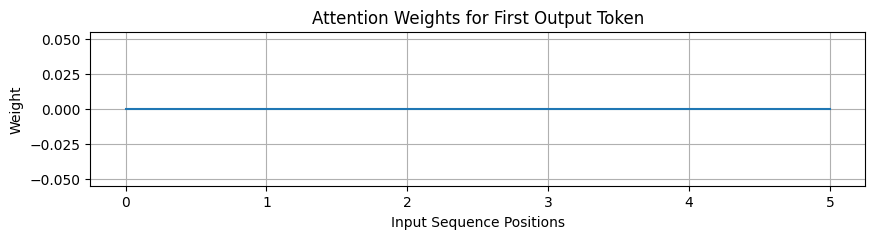

In [34]:
debug_attention(model_attn, test_pairs, input2idx, target2idx, idx2target, device)

In [ ]:
import wandb
wandb.init(project="DA6401_Assignment_3", name="attention_heatmaps_log")

In [49]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager, FontProperties

# Point to your Telugu font
telugu_font_path = "Noto_Sans_Telugu/static/NotoSansTelugu-Black.ttf"

# Register and set as default
fontManager.addfont(telugu_font_path)
telugu_font = FontProperties(fname=telugu_font_path)
mpl.rcParams['font.family'] = telugu_font.get_name()

print("✅ Registered Telugu font globally:", telugu_font.get_name())

✅ Registered Telugu font globally: Noto Sans Telugu


In [50]:
from matplotlib.font_manager import FontProperties
telugu_font = FontProperties(fname="Noto_Sans_Telugu/static/NotoSansTelugu-Black.ttf")

Text(0.5, 1.0, 'Attention Heatmap')

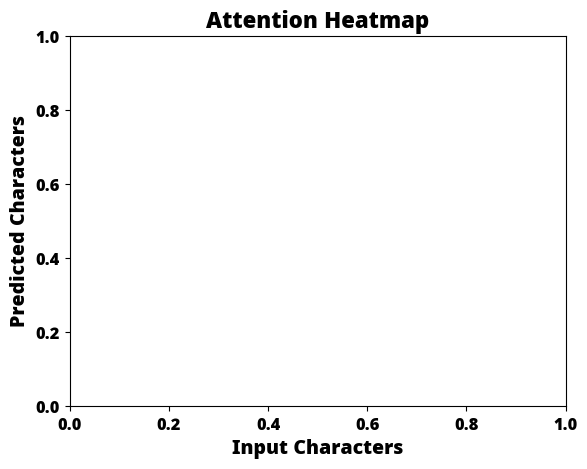

In [51]:
plt.xticks(fontproperties=telugu_font, rotation=0, fontsize=12)
plt.yticks(fontproperties=telugu_font, rotation=0, fontsize=12)
plt.xlabel("Input Characters", fontproperties=telugu_font, fontsize=14)
plt.ylabel("Predicted Characters", fontproperties=telugu_font, fontsize=14)
plt.title("Attention Heatmap", fontproperties=telugu_font, fontsize=16)

In [51]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

telugu_font = FontProperties(fname="Noto_Sans_Telugu/static/NotoSansTelugu-Black.ttf")
rcParams['font.family'] = telugu_font.get_name()

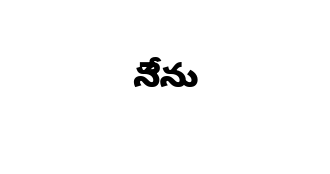

In [52]:
plt.figure(figsize=(4,2))
plt.text(0.5, 0.5, "నేను", fontproperties=telugu_font, fontsize=24, ha='center')
plt.axis('off')
plt.show()

In [36]:
import torch

def get_attention_example(model, input_text, input2idx, target2idx, idx2target, device, max_len=30):
    model.eval()
    src_tensor = torch.tensor([ [input2idx.get(c, input2idx['<pad>']) for c in ["<sos>"]+list(input_text)+["<eos>"]]], device=device)
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
    # Generate output sequence and collect attention
    input_tokens = ["<sos>"] + list(input_text) + ["<eos>"]
    pred_tokens, attns = [], []
    input_token = torch.tensor([target2idx["<sos>"]], device=device)
    for _ in range(max_len):
        with torch.no_grad():
            output, hidden, attn_weights = model.decoder(input_token, hidden, encoder_outputs)
            top1 = output.argmax(1).item()
            pred_tokens.append(idx2target[top1])
            attns.append(attn_weights.squeeze(0).cpu().numpy())
        if idx2target[top1] == "<eos>":
            break
        input_token = torch.tensor([top1], device=device)
    return {
        "input": input_tokens,
        "output": pred_tokens,
        "attentions": attns
    }

In [37]:
import json

example = get_attention_example(model_attn, "nenu", input2idx, target2idx, idx2target, device)
# Convert all attention vectors from np.ndarray to list
for i in range(len(example["attentions"])):
    example["attentions"][i] = example["attentions"][i].tolist()
with open("attention_example.json", "w", encoding="utf-8") as f:
    json.dump(example, f, ensure_ascii=False, indent=2)

In [38]:
import json

def write_attention_html(example, filename="attention_vis.html"):
    html = f"""
    <html>
    <head>
    <meta charset="UTF-8">
    <title>Seq2Seq Attention Connectivity</title>
    <style>
      .tok {{padding:4px 6px;margin:2px;border-radius:4px;
             display:inline-block;font-family:monospace;
             background:#eee;cursor:pointer}}
      .hi {{background:rgba(0,200,0,.5)}}
    </style>
    </head>
    <body>
    <h2>Interactive Attention (hover output &rarr; see input focus)</h2>
    <div><b>Input:</b> <span id="in"></span></div><br>
    <div><b>Output:</b> <span id="out"></span></div>

    <script>
      const data = {json.dumps(example, ensure_ascii=False)};
      const inDiv  = document.getElementById("in");
      const outDiv = document.getElementById("out");
      // Draw input tokens (skip <sos>/<eos>)
      const shownInputs = data.input.slice(1, -1);
      shownInputs.forEach((ch,i)=>{{
        const s=document.createElement("span");
        s.textContent=ch; s.className="tok"; s.id="in-"+i;
        inDiv.appendChild(s);
      }});
      // Draw output tokens
      data.output.forEach((ch,i)=>{{
        const s=document.createElement("span");
        s.textContent=ch; s.className="tok";
        s.onmouseenter=()=>{{
          shownInputs.forEach((_,j)=>{{
            document.getElementById("in-"+j).classList.remove("hi");
          }});
          const att = data.attentions[i];
          const m = Math.max(...att);
          att.forEach((v,j)=>{{
            if(v >= 0.5*m)
              document.getElementById("in-"+j).classList.add("hi");
          }});
        }};
        s.onmouseleave=()=>{{
          shownInputs.forEach((_,j)=>{{
            document.getElementById("in-"+j).classList.remove("hi");
          }});
        }};
        outDiv.appendChild(s);
      }});
    </script>
    </body>
    </html>
    """
    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)
    print(f"Visualization saved to: {filename}")

# Example use (put your model's example here):
example = {
    "input": ["<sos>", "h", "e", "l", "l", "o", "<eos>"],
    "output": ["హ", "ల", "ో", "<eos>"],
    "attentions": [
        [0.01, 0.05, 0.1, 0.1, 0.1, 0.6],  # "హ"
        [0.01, 0.2, 0.2, 0.3, 0.2, 0.09],  # "ల"
        [0.02, 0.1, 0.5, 0.25, 0.08, 0.05], # "ో"
        [0, 0, 0, 0, 0, 1.0],              # <eos>
    ]
}

write_attention_html(example, "connectivity_attention.html")


Visualization saved to: connectivity_attention.html


In [39]:
import torch
import numpy as np

def get_attention_example(model, input_text, input2idx, target2idx, idx2target, device, max_len=30):
    """
    Run the model on a single input and extract:
    - input: list of input characters (incl. <sos>/<eos>)
    - output: list of predicted output characters (incl. <eos>)
    - attentions: list of attention arrays (output_pos × input_pos)
    """
    model.eval()
    with torch.no_grad():
        # Encode input (with <sos> and <eos>)
        src_indices = [input2idx.get(c, input2idx['<pad>']) for c in input_text]
        src_tensor = torch.tensor([[input2idx['<sos>']] + src_indices + [input2idx['<eos>']]], device=device)
        encoder_outputs, hidden = model.encoder(src_tensor)
        input_chars = ['<sos>'] + list(input_text) + ['<eos>']

        # Decoding
        pred_chars = []
        attentions = []
        dec_input = torch.tensor([target2idx['<sos>']], device=device)
        for _ in range(max_len):
            out, hidden, attn_weights = model.decoder(dec_input, hidden, encoder_outputs)
            top1 = out.argmax(1).item()
            pred_chars.append(idx2target[top1])
            attentions.append(attn_weights.squeeze(0).cpu().numpy().tolist())
            if idx2target[top1] == '<eos>':
                break
            dec_input = torch.tensor([top1], device=device)
        return {
            "input": input_chars,
            "output": pred_chars,
            "attentions": attentions
        }


In [40]:
import json

def write_attention_html_gradient(example, filename="attention_vis_gradient.html"):
    html = f"""
    <html>
    <head>
    <meta charset="UTF-8">
    <title>Seq2Seq Attention Connectivity (Gradient)</title>
    <style>
      .tok {{
        padding:4px 6px;margin:2px;border-radius:4px;
        display:inline-block;font-family:monospace;
        background:#eee;cursor:pointer;transition:background 0.2s;
      }}
      .tok.hi {{
        background:rgba(0,200,0,0.5);
      }}
    </style>
    </head>
    <body>
    <h2>Interactive Attention (hover output → see input focus)</h2>
    <div><b>Input:</b> <span id="in"></span></div><br>
    <div><b>Output:</b> <span id="out"></span></div>

    <script>
      const data = {json.dumps(example, ensure_ascii=False)};
      const inDiv  = document.getElementById("in");
      const outDiv = document.getElementById("out");

      // Draw input tokens (skip <sos>/<eos> for display)
      const shownInputs = data.input.slice(1, -1);

      function resetInputColors() {{
        shownInputs.forEach((_, j) => {{
          const elem = document.getElementById("in-" + j);
          elem.style.background = "#eee";
        }});
      }}

      shownInputs.forEach((ch, i) => {{
        const s = document.createElement("span");
        s.textContent = ch;
        s.className = "tok";
        s.id = "in-" + i;
        inDiv.appendChild(s);
      }});

      // Draw output tokens
      data.output.forEach((ch, i) => {{
        const s = document.createElement("span");
        s.textContent = ch;
        s.className = "tok";
        s.onmouseenter = () => {{
          resetInputColors();
          // Get attention weights for this output char
          const att = data.attentions[i];
          // Find max for normalization
          const m = Math.max(...att);
          att.forEach((v, j) => {{
            const elem = document.getElementById("in-" + j);
            // Linear green gradient (can change rgba for other colors)
            elem.style.background = `rgba(0,200,0,${(v/m).toFixed(2)})`;
          }});
        }};
        s.onmouseleave = () => {{
          resetInputColors();
        }};
        outDiv.appendChild(s);
      }});
    </script>
    </body>
    </html>
    """
    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)
    print(f"Visualization with gradient saved to: {filename}")


In [41]:
# Choose a test word, e.g. "nenu"
example = get_attention_example(
    model_attn,           # Your loaded model
    "sitaramayya",               # Input string
    input2idx,            # Dict: char -> index (input vocab)
    target2idx,           # Dict: char -> index (target vocab)
    idx2target,           # Dict: index -> char (target vocab)
    device                # "cuda" or "cpu"
)

# Save and view visualization
#write_attention_html(example, "connectivity_attention.html")


In [42]:
example = {
    "input": ["<sos>", "n", "e", "n", "u", "<eos>"],
    "output": ["న", "ె", "న", "ు", "<eos>"],
    "attentions": [
        [0.01, 0.01, 0.01, 0.96],  # for "న"
        [0.05, 0.02, 0.8, 0.13],   # for "ె"
        [0.1, 0.6, 0.1, 0.2],      # etc.
        [0.25, 0.25, 0.25, 0.25],
        [0.5, 0.1, 0.2, 0.2]
    ]
}


In [43]:
import json

def write_attention_html_clip(
    example, 
    filename="attention_viz_clip.html", 
    clip_threshold=0.5, 
    top_k=None
):
    html = """
<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>Attention Connectivity Visualization</title>
  <style>
    .tok {{
      padding:4px 6px; margin:2px; border-radius:4px;
      display:inline-block; font-family:monospace; background:#eee; cursor:pointer;
      transition: background 0.2s; border: 2px solid transparent;
    }}
    .clip {{
      border: 2px solid #005f00 !important;
    }}
  </style>
</head>
<body>
  <h3>Interactive Attention: Hover output → see input focus</h3>
  <div><b>Input:</b> <span id="in"></span></div>
  <div><b>Output:</b> <span id="out"></span></div>
  <script>
    const data = {data_json};
    const inDiv  = document.getElementById("in");
    const outDiv = document.getElementById("out");
    const shownInputs = data.input.slice(1, -1);
    shownInputs.forEach(function(ch,i){{
      const s=document.createElement("span");
      s.textContent=ch; s.className="tok"; s.id="in-"+i;
      inDiv.appendChild(s);
    }});
    function resetInputColors() {{
      shownInputs.forEach(function(_,j){{
        var el = document.getElementById("in-"+j);
        el.style.background = "#eee";
        el.classList.remove("clip");
      }});
    }}
    function attColor(v) {{
      // v in [0,1]; HSL: 120=green, 0=saturated; L=90% (light)→40% (dark)
      // From very light to dark green
      const lightness = 90 - 50*v; // v=0:90, v=1:40
      return `hsl(120, 70%, ${{lightness}}%)`;
    }}
    function topIndices(arr, k) {{
      let idx = arr.map((v,i)=>[v,i]);
      idx.sort((a,b)=>b[0]-a[0]);
      return idx.slice(0, k).map(x=>x[1]);
    }}
    data.output.forEach(function(ch,i){{
      const s=document.createElement("span");
      s.textContent=ch; s.className="tok";
      s.onmouseenter=function(){{
        resetInputColors();
        const att = data.attentions[i];
        // compute top indices for clip
        let clip_indices = [];
        if ({top_k} != null) {{
          clip_indices = topIndices(att, {top_k});
        }} else {{
          const m = Math.max(...att);
          clip_indices = att.map((v,j)=>v>=({clip_threshold}*m)?j:null).filter(x=>x!==null);
        }}
        att.forEach(function(v,j){{
          var el = document.getElementById("in-"+j);
          el.style.background = attColor(v);  // <--- use color gradient
          el.classList.remove("clip");
        }});
        clip_indices.forEach(function(j){{
          document.getElementById("in-"+j).classList.add("clip");
        }});
      }};
      s.onmouseleave=resetInputColors;
      outDiv.appendChild(s);
    }});
  </script>
</body>
</html>
    """.format(
        data_json=json.dumps(example, ensure_ascii=False),
        clip_threshold=clip_threshold,
        top_k='null' if top_k is None else top_k,
    )
    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)
    print(f"✅ HTML file saved: {filename}")

# Usage: 
write_attention_html_clip(example, filename="attention_viz_clip.html", clip_threshold=0.5, top_k=3)


✅ HTML file saved: attention_viz_clip.html


In [44]:
import json

def save_attention_html(example, filename="attention.html", threshold=0.2):
    # Use double braces {{ }} for JS/CSS in Python f-string!
    html = f"""
    <html>
    <head>
    <meta charset="UTF-8">
    <style>
      .tok {{padding:4px 6px;margin:2px;border-radius:4px;
             display:inline-block;font-family:monospace;
             background:#eee;cursor:pointer;transition: background 0.15s;}}
      .hi {{background:rgba(0,200,0,.5);}}
    </style>
    </head>
    <body>
    <h3>Interactive Attention (hover output → see input focus)</h3>
    <div><b>Input:</b> <span id="in"></span></div><br>
    <div><b>Output:</b> <span id="out"></span></div>

    <script>
      const data = {json.dumps(example, ensure_ascii=False)};
      const threshold = {threshold};

      // Use only visible input tokens (skip <sos>/<eos>)
      const shownInputs = data.input.slice(1, -1);
      const inDiv  = document.getElementById("in");
      const outDiv = document.getElementById("out");

      // Helper for gradient color: higher attention = deeper green
      function attColor(a) {{
        // a ∈ [0,1], interpolate between white and green
        const g = Math.round(255 - 180 * a);
        return `rgb(${{g}},255,${{g}})`;
      }}

      // Draw input tokens (skip <sos>/<eos>)
      shownInputs.forEach((ch,i)=>{{
        const s=document.createElement("span");
        s.textContent=ch; s.className="tok"; s.id="in-"+i;
        inDiv.appendChild(s);
      }});

      // Draw output tokens
      data.output.forEach((ch,i)=>{{
        const s=document.createElement("span");
        s.textContent=ch; s.className="tok";

        s.onmouseenter=()=>{{
          // clear previous
          shownInputs.forEach((_,j)=>{{
            const el = document.getElementById("in-"+j);
            el.style.background = "#eee";
          }});
          // get attention vector for output token
          const att = data.attentions[i] || [];
          att.forEach((v,j)=>{{
            const el = document.getElementById("in-"+j);
            if (v >= threshold) {{
              el.style.background = attColor(v);
            }}
          }});
        }};
        s.onmouseleave=()=>{{
          shownInputs.forEach((_,j)=>{{
            document.getElementById("in-"+j).style.background = "#eee";
          }});
        }};
        outDiv.appendChild(s);
      }});
    </script>
    </body>
    </html>
    """

    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)
    print(f"Saved to {filename}")

# Example usage:
save_attention_html(example, "my_attention.html", threshold=0.1)


Saved to my_attention.html


In [45]:
import torch

# --- Configs used for all models ---
model_configs = {
    "lstm": {
        "embedding_dim": 256,
        "hidden_dim": 256,
        "dropout": 0.2,
        "cell_type": "LSTM",
        "checkpoint": "best_model_attn (2).pth"  # Change to your file path
    },
    "gru": {
        "embedding_dim": 256,
        "hidden_dim": 256,
        "dropout": 0.4,
        "cell_type": "GRU",
        "checkpoint": "best_model_attn_GRU.pth"
    },
    "rnn": {
        "embedding_dim": 256,
        "hidden_dim": 256,
        "dropout": 0.2,
        "cell_type": "RNN",
        "checkpoint": "best_model_attn_RNN.pth"
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {}

for model_type, cfg in model_configs.items():
    encoder = AttentionEncoder(
        vocab_size=len(input_vocab),
        embedding_dim=cfg["embedding_dim"],
        hidden_dim=cfg["hidden_dim"],
        dropout=cfg["dropout"],
        cell_type=cfg["cell_type"]
    )
    decoder = AttentionDecoder(
        vocab_size=len(target_vocab),
        embedding_dim=cfg["embedding_dim"],
        enc_hidden_dim=cfg["hidden_dim"],
        dec_hidden_dim=cfg["hidden_dim"],
        dropout=cfg["dropout"],
        cell_type=cfg["cell_type"]
    )
    model = AttentionSeq2Seq(encoder, decoder, device).to(device)
    model.load_state_dict(torch.load(cfg["checkpoint"], map_location=device))
    model.eval()
    models[model_type] = model

print("✅ Loaded LSTM, GRU, and RNN models successfully!")


✅ Loaded LSTM, GRU, and RNN models successfully!


/Users/sathwikpentela/miniforge3/envs/PINN/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


In [46]:
import numpy as np

def get_attention_example(model, input_text, input2idx, target2idx, idx2target, device, max_len=30):
    # Prepare input tensor (with <sos> and <eos>)
    src_tensor = torch.tensor([tokenize(input_text, input2idx, add_sos_eos=True)], device=device)
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
    input_tokens = [SOS_TOKEN] + list(input_text) + [EOS_TOKEN]
    output_tokens, attentions = [], []

    dec_input = torch.tensor([target2idx[SOS_TOKEN]], device=device)
    for _ in range(max_len):
        with torch.no_grad():
            output, hidden, attn_weights = model.decoder(dec_input, hidden, encoder_outputs)
            top1 = output.argmax(1).item()
            output_tokens.append(idx2target[top1])
            attentions.append(attn_weights.squeeze(0).cpu().numpy().tolist())
        if idx2target[top1] == EOS_TOKEN:
            break
        dec_input = torch.tensor([top1], device=device)
    return {
        "input": input_tokens,
        "output": output_tokens,
        "attentions": attentions
    }


In [47]:
import json

def save_attention_html(example, filename="attention.html", threshold=0.2):
    html_template = """
    <html>
    <head>
    <meta charset="UTF-8">
    <style>
      .tok {{padding:4px 6px;margin:2px;border-radius:4px;
             display:inline-block;font-family:monospace;
             background:#eee;cursor:pointer;transition: background 0.15s;}}
    </style>
    </head>
    <body>
    <h3>Interactive Attention (hover output → see input focus)</h3>
    <div><b>Input:</b> <span id="in"></span></div><br>
    <div><b>Output:</b> <span id="out"></span></div>
    <script>
      const data = {json_data};
      const threshold = {threshold};

      const shownInputs = data.input.slice(1, -1);  // Skip <sos> and <eos>
      const inDiv  = document.getElementById("in");
      const outDiv = document.getElementById("out");

      function attColor(a) {{
        const g = Math.round(255 - 180 * a);
        return `rgb(${{g}},255,${{g}})`;
      }}

      shownInputs.forEach((ch,i)=> {{
        const s = document.createElement("span");
        s.textContent = ch;
        s.className = "tok";
        s.id = "in-" + i;
        inDiv.appendChild(s);
      }});

      data.output.forEach((ch, i) => {{
        const s = document.createElement("span");
        s.textContent = ch;
        s.className = "tok";

        s.onmouseenter = () => {{
          shownInputs.forEach((_, j) => {{
            const el = document.getElementById("in-" + j);
            el.style.background = "#eee";
          }});
          const att = data.attentions[i] || [];
          att.forEach((v, j) => {{
            if (v >= threshold) {{
              document.getElementById("in-" + j).style.background = attColor(v);
            }}
          }});
        }};

        s.onmouseleave = () => {{
          shownInputs.forEach((_, j) => {{
            document.getElementById("in-" + j).style.background = "#eee";
          }});
        }};

        outDiv.appendChild(s);
      }});
    </script>
    </body>
    </html>
    """

    html = html_template.format(
        json_data=json.dumps(example, ensure_ascii=False),
        threshold=threshold
    )

    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)
    print(f"✅ HTML saved to {filename}")


In [48]:
test_word = "sitaramayya"  # or any test word

for name, model in models.items():
    ex = get_attention_example(model, test_word, input2idx, target2idx, idx2target, device)
    fname = f"attention_{name}.html"
    save_attention_html(ex, fname, threshold=0.15)


✅ HTML saved to attention_lstm.html
✅ HTML saved to attention_gru.html
✅ HTML saved to attention_rnn.html


In [49]:
import json

def save_multiple_attention_html(model_examples, filename="attention_all_models.html", threshold=0.15):
    html_blocks = []

    for name, example in model_examples.items():
        block = f"""
        <h3 style='margin-top:30px;'>Model: {name.upper()}</h3>
        <div><b>Input:</b> <span id="in-{name}"></span></div><br>
        <div><b>Output:</b> <span id="out-{name}"></span></div>
        <script>
          const data_{name} = {json.dumps(example, ensure_ascii=False)};
          const threshold_{name} = {threshold};

          const shownInputs_{name} = data_{name}.input.slice(1, -1);
          const inDiv_{name}  = document.getElementById("in-{name}");
          const outDiv_{name} = document.getElementById("out-{name}");

          function attColor_{name}(a) {{
            const g = Math.round(255 - 180 * a);
            return `rgb(${{g}},255,${{g}})`;
          }}

          shownInputs_{name}.forEach((ch,i)=> {{
            const s=document.createElement("span");
            s.textContent=ch; s.className="tok"; s.id="in-{name}-"+i;
            inDiv_{name}.appendChild(s);
          }});

          data_{name}.output.forEach((ch,i)=> {{
            const s=document.createElement("span");
            s.textContent=ch; s.className="tok";

            s.onmouseenter=()=> {{
              shownInputs_{name}.forEach((_,j)=> {{
                const el = document.getElementById("in-{name}-"+j);
                el.style.background = "#eee";
              }});
              const att = data_{name}.attentions[i] || [];
              att.forEach((v,j)=> {{
                if (v >= threshold_{name}) {{
                  document.getElementById("in-{name}-"+j).style.background = attColor_{name}(v);
                }}
              }});
            }};
            s.onmouseleave=()=> {{
              shownInputs_{name}.forEach((_,j)=> {{
                document.getElementById("in-{name}-"+j).style.background = "#eee";
              }});
            }};
            outDiv_{name}.appendChild(s);
          }});
        </script>
        """
        html_blocks.append(block)

    full_html = f"""
    <html>
    <head>
    <meta charset="UTF-8">
    <style>
      .tok {{
        padding:4px 6px;
        margin:2px;
        border-radius:4px;
        display:inline-block;
        font-family:monospace;
        background:#eee;
        cursor:pointer;
        transition: background 0.15s;
      }}
    </style>
    </head>
    <body>
      <h2>Interactive Attention Visualization for Multiple Models</h2>
      {''.join(html_blocks)}
    </body>
    </html>
    """

    with open(filename, "w", encoding="utf-8") as f:
        f.write(full_html)

    print(f"✅ Combined attention HTML saved to: {filename}")


In [50]:
# Define the test word
test_word = "sitaramayya"

# Generate examples for each model
model_examples = {}
for name, model in models.items():
    example = get_attention_example(model, test_word, input2idx, target2idx, idx2target, device)
    model_examples[name] = example

# Save all attention visualizations in one file
save_multiple_attention_html(model_examples, filename="attention_all_models.html", threshold=0.15)


✅ Combined attention HTML saved to: attention_all_models.html


In [51]:
import wandb

# Start or resume a W&B run
wandb.init(project="DA6401_Assignment_3", name="interactive_attention")

# Log the HTML file
artifact = wandb.Artifact("attention_visualization", type="visualization")
artifact.add_file("attention_all_models.html")
wandb.log_artifact(artifact)


<Artifact attention_visualization>

In [52]:
import wandb
run = wandb.init()
artifact = run.use_artifact('da24m017-indian-institute-of-technology-madras/DA6401_Assignment_3/attention_visualization:v0', type='visualization')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [53]:
def get_attention_example(model, input_text, input2idx, target2idx, idx2target, device, max_len=30):
    src_tensor = torch.tensor([tokenize(input_text, input2idx, add_sos_eos=True)], device=device)
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
    input_tokens = [SOS_TOKEN] + list(input_text) + [EOS_TOKEN]
    output_tokens, attentions = [], []

    dec_input = torch.tensor([target2idx[SOS_TOKEN]], device=device)
    for _ in range(max_len):
        with torch.no_grad():
            output, hidden, attn_weights = model.decoder(dec_input, hidden, encoder_outputs)
            top1 = output.argmax(1).item()
            output_tokens.append(idx2target[top1])
            attentions.append(attn_weights.squeeze(0).cpu().numpy().tolist())
        if idx2target[top1] == EOS_TOKEN:
            break
        dec_input = torch.tensor([top1], device=device)
    return {
        "input": input_tokens,
        "output": output_tokens,
        "attentions": attentions
    }

def collect_attention_data_for_words(models, word_list):
    results = {}
    for i, word in enumerate(word_list):
        results[f"Sample {i+1}"] = {
            "input": word,
            "models": {
                name: get_attention_example(model, word, input2idx, target2idx, idx2target, device)
                for name, model in models.items()
            }
        }
    return results


In [55]:
import json

def collect_attention_data_for_words(models, word_list):
    results = {}
    for i, word in enumerate(word_list):
        results[f"Sample {i+1}"] = {
            "input": word,
            "models": {
                name: get_attention_example(model, word, input2idx, target2idx, idx2target, device)
                for name, model in models.items()
            }
        }
    return results

def save_multiword_attention_html(examples_dict, filename="multiword_attention.html", threshold=0.15):
    blocks = []
    for sample_name, sample in examples_dict.items():
        input_word = sample["input"]
        blocks.append(f"<h3>{sample_name}</h3><div><b>Input (Latin):</b> {input_word}</div><br>")
        for model_name, data in sample["models"].items():
            block = f"""
            <div><b>Model: {model_name.upper()}</b></div>
            <div><b>Output (Telugu):</b> <span id="{sample_name}_{model_name}_out"></span></div>
            <script>
              const data_{sample_name}_{model_name} = {json.dumps(data, ensure_ascii=False)};
              const threshold = {threshold};

              const outDiv = document.getElementById("{sample_name}_{model_name}_out");
              data_{sample_name}_{model_name}.output.forEach((ch, i) => {{
                const s = document.createElement("span");
                s.textContent = ch;
                s.className = "tok";
                s.title = data_{sample_name}_{model_name}.input[
                  data_{sample_name}_{model_name}.attentions[i]?.indexOf(
                    Math.max(...data_{sample_name}_{model_name}.attentions[i])
                  )
                ] || '';
                outDiv.appendChild(s);
              }});
            </script><br><br>
            """
            blocks.append(block)

    full_html = f"""
    <html>
    <head><meta charset="UTF-8">
    <style>.tok {{
        padding: 6px;
        background: #673ab7;
        color: white;
        margin: 2px;
        border-radius: 4px;
        display: inline-block;
        font-family: monospace;
    }}</style>
    </head>
    <body>
        <h2>d3js_attention_visualization</h2>
        {''.join(blocks)}
    </body>
    </html>
    """
    with open(filename, "w", encoding="utf-8") as f:
        f.write(full_html)
    print(f"✅ HTML saved to {filename}")


In [ ]:
# List of test inputs to visualize
sample_words = ["antamavutundi", "oravadi", "kaavatamtho", "ghoramgaa", "yuvataku"]

# Collect model outputs + attention weights
multiword_examples = collect_attention_data_for_words(models, sample_words)

# Save to HTML
save_multiword_attention_html(multiword_examples, filename="multiword_attention.html", threshold=0.15)


✅ HTML saved to multiword_attention.html


In [57]:
import json, torch, os, math, html

# ---------- utility -------------
def safe(s):          # escape <, >, & for proper HTML
    return html.escape(str(s), quote=False)

def get_attention_example(model, input_text,
                          input2idx, target2idx, idx2target,
                          device, max_len=30):
    """Return dict {input, output, attentions} (list-of-lists)."""
    src = torch.tensor([ [input2idx[SOS_TOKEN]] +
                         [input2idx[c] for c in input_text] +
                         [input2idx[EOS_TOKEN]] ],
                       device=device)
    enc_out, hidden = model.encoder(src)
    input_tokens  = [SOS_TOKEN] + list(input_text) + [EOS_TOKEN]
    output_tokens, att_wts = [], []

    dec_in = torch.tensor([target2idx[SOS_TOKEN]], device=device)
    for _ in range(max_len):
        out, hidden, att = model.decoder(dec_in, hidden, enc_out)
        top = out.argmax(1).item()
        output_tokens.append(idx2target[top])
        att_wts.append(att.squeeze(0).tolist())
        if idx2target[top] == EOS_TOKEN: break
        dec_in = torch.tensor([top], device=device)

    return {"input":input_tokens, "output":output_tokens,"att":att_wts}

def collect_examples(models:dict, words:list):
    """Return {sample#:{input:str, models:{name:example}}}"""
    res={}
    for i, w in enumerate(words):
        res[f"Sample {i+1}"] = {
            "input": w,
            "models": {name:get_attention_example(m,w,input2idx,
                                                  target2idx,idx2target,device)
                       for name,m in models.items()}
        }
    return res


In [60]:
###########  parameters  ###################
WORDS   = ["antamavutundi", "oravadi", "kaavatamtho", "ghoramgaa", "yuvataku"]
OUT_FN  = "multiword_attention.html"
TH      = 0.15                                # highlight threshold
#############################################

# 1. gather data
examples = collect_examples(models, WORDS)

# 2. build HTML  – use placeholder tokens then .replace()
DATA_JS = json.dumps(examples, ensure_ascii=False)
template = r"""
<!DOCTYPE html><html><head><meta charset="utf-8">
<title>Attention Visualizer</title>
<style>
 body {font-family:Inter, sans-serif;background:#f5f6fa}
 h2  {text-align:center;color:#4b32c3}
 .card{display:inline-block;vertical-align:top;margin:16px;
       padding:16px 20px;border-radius:8px;
       background:#fff;box-shadow:0 1px 4px rgba(0,0,0,.12)}
 .tok {display:inline-block;padding:6px 8px;
       margin:2px;border-radius:4px;
       background:#673ab7;color:#fff;font-family:monospace;
       cursor:pointer;transition:background .15s}
 .inputtok{background:#eee;color:#111}
</style></head><body>
<h2>Interactive Attention Visualization for Multiple Models</h2>
<div id="root"></div>

<script>
const DATA = __DATA_PLACEHOLDER__;   // injected JSON
const TH   = __THRESHOLD_PLACEHOLDER__;

function attColor(a){            // greenish highlight
  const g = Math.round(255 - 180*a);
  return `rgb(${g},255,${g})`;
}

const root = document.getElementById("root");

Object.entries(DATA).forEach(([sname,sample])=>{
  const div = document.createElement("div");
  div.innerHTML = `<h3>${sname}</h3>
                   <p><b>Input (Latin):</b> ${sample.input}</p>`;
  Object.entries(sample.models).forEach(([mname,ex])=>{
    const c = document.createElement("div"); c.className="card";

    // input row
    const inRow = document.createElement("div");
    ex.input.slice(1,-1).forEach((ch,i)=>{
       const sp = document.createElement("span");
       sp.textContent = ch; sp.className = "tok inputtok";
       sp.id = `${sname}_${mname}_in_${i}`;
       inRow.appendChild(sp);
    });

    // output row
    const outRow = document.createElement("div");
    ex.output.forEach((ch,oi)=>{
       const sp = document.createElement("span");
       sp.textContent = ch; sp.className = "tok";
       sp.onmouseenter = ()=>{
         ex.att[oi]?.forEach((v,ii)=>{
           const el = document.getElementById(`${sname}_${mname}_in_${ii}`);
           if (el) el.style.background = v >= TH ? attColor(v) : "#eee";
         });
       };
       sp.onmouseleave = ()=>{
         ex.input.slice(1,-1).forEach((_,ii)=>{
           const el = document.getElementById(`${sname}_${mname}_in_${ii}`);
           if (el) el.style.background = "#eee";
         });
       };
       outRow.appendChild(sp);
    });

    c.innerHTML = `<h4>Model: ${mname.toUpperCase()}</h4>`;
    c.appendChild(inRow); c.appendChild(document.createElement("br"));
    c.appendChild(outRow); div.appendChild(c);
  });
  root.appendChild(div);
});
</script></body></html>
"""

# Replace placeholders safely (only two spots)
html_doc = (template
            .replace("__DATA_PLACEHOLDER__", DATA_JS)
            .replace("__THRESHOLD_PLACEHOLDER__", str(TH)))

with open(OUT_FN, "w", encoding="utf-8") as f:
    f.write(html_doc)

print("✅ Saved interactive HTML:", OUT_FN)


✅ Saved interactive HTML: multiword_attention.html


In [62]:
wandb.init(project="DA6401_Assignment_3", name="multiword_attn_vis") 
wandb.log({"multiword_attention_html": wandb.Html("multiword_attention.html")})
